## Introduction 

***Principe de l'algorithme de liste :***

La méthode de liste permet de classer les tâches selon un ordre de priorité. Les tâches sont alors ordonnancées en incrémentant le temps à partir de l ’instant initial 0.

A chaque instant t, on ordonnance parmi les tâches prêtes la tâche de plus haute priorité. L’ordre de priorité peut être statique ou dynamique, c’est-à-dire évoluer ou non au cours du temps.

Les méthodes de liste sont très utilisées en pratique car elles permettent d ’obtenir rapidement une solution.

## Paramètres généraux 

On définit un **nombre de patients** dans la zone d'attente, un **nombre de capacités** disponible au sein du SUA et un **temps de traitement** pour chaque tâche de soin nécessitant l'intervention d'une certaine capacité.

In [ ]:
import random as rd

nb_patients = 20    # nombre de patients dans la salle d'attente arrivés tous au même temps

In [ ]:
nb_capacités = 6  # nombre de capacités disponibles au sein du SUA

In [ ]:
# temps nécessaire de traitement pour chaque capacité disponible (en minutes)
temps_capacité = rd.choices([20, 30, 40, 50], k = nb_capacités)


Ensuite, on définira la classe ***Patient*** avec les capacités nécessaires à son traitement et son temps d'attente initial au cours de l'enregistrement et /ou diagnostic primaire. 

On choisit de définir tous les patients dans la salle d'attente avec le même critère CCMU = 2 et cela pour deux raisons:
 - focaliser l'attention sur l'amélioration du temps d'attente primaire des patients
 - l'exploitation des données du CHU de Lille permet de montrer que 2% seulement des patients sont affectés d'un CCMU grave.

In [ ]:
class Patient:
  def __init__(self, id):
    self.id = id
    self.attente = rd.randint(0,40)  # temps d'attente initial durant l'enregistrement/le diagnostic
    self.nb_thérapies = rd.randint(1, 4)  # un nombre aléatoire de thérapies à effectuer
    self.taches = rd.sample(range(0, nb_capacités), self.nb_thérapies)   # liste des tâches de soins
    self.ccmu = 2
    self.nb_restant =self.nb_thérapies # nombre de thérapies à effectuer 

  def score(self, attente, nb_restant):
    """ Permet de calculer le score fitness de chaque patient
    capacité : indice de la tâche de soin en cours 
    """
    score = self.ccmu*(attente/60)* nb_restant/self.nb_thérapies
    return score

On définit ainsi tous les patients dans la zone d'attente

In [ ]:
salle_attente = [Patient(i) for i in range(nb_patients)]

En fonction des tâches de soins nécessaires pour chaque patient, on définit pour chaque capacité la liste des patients à traiter

In [ ]:
# on définit le passage des patients par chaque capacité
passage_par_capacité = [[] for i in range(nb_capacités)]
for patient in salle_attente:
  for tache in patient.taches:
    passage_par_capacité[tache].append(patient.id)

print(passage_par_capacité)


[[3, 5, 7, 8, 9, 12, 13, 15, 18], [3, 4, 9, 10, 11, 14, 15, 16, 18], [5, 9, 10, 11, 12, 16, 17], [3, 4, 6, 7, 9, 12, 13, 14, 15, 17, 19], [2, 3, 5, 7, 8, 13, 15], [0, 1, 4, 5, 7, 11, 14, 16]]


In [ ]:
len(passage_par_capacité)

6

In [ ]:
# on calcule le nombre d'opérations à ordonnancer
nb_op = 0
for liste in passage_par_capacité:
  nb_op += len(liste)

print(nb_op)

50


## Algorithme de liste 


On developpe un algorithme de liste qui permet d'ordonnancer les patients selon un score prenant en compte : 
- le ***CCMU*** des patients (prioriser les patients dans un état critique)
- le ***temps d'attente primaire*** des patients
- le ***nombre de tâches de soins qui restent*** au patient d'effectuer
selon la formule : 
      score = CCMU*(temps d'attente primaire/60 )* (nombre de thérapies restantes / nombre total de thérapies à effectuer)

  **NB** : la division du temps d'attente primaire / 60 sert à normaliser le temps donné initialement en minutes.

***Principe de fonctionnement***:
- on ordonnance les tâches de soins en commençant par la première capacité jusqu'à la dernière (valoriser la contrainte de précédence et non-permutabilité des tâches de soins)

- les patients dont le traitement nécessite l'intervention d'une certaine capacité sont ensuite ordonnés selon le score défini précédemment

In [ ]:
def ordonnancer():
  """
  schedule : une liste de tuples  : [ [( , , ), ( , , ), ( , , )],
                                      [( , , ), ( , , ), ( , , )], 
                                      [( , , ), ( , , ), ( , , )]  ]
   - Chaque ligne représente l'ordre des thérapies d'un patient précis
   - ( , , ) : la 1ère entrée représente l'indice de la capacité nécessaire, 2ème entrée temps 
  de début de la thérapie et la 3ème temps de fin                
  """
  schedule = [[] for _ in range(nb_patients)]

  # temps d'attente primaire des patients = temps d'attente avant la première consultation 
  attente_primaire = [patient.attente for patient in salle_attente]

  nb_restants = [patient.nb_restant for patient in salle_attente]

  # disponibiliés en temps réel des tâches de soins offertes au SUA
  dispo_capacités = [0 for i in range(nb_capacités)]

  # ordonnancer
  for capacité in range(len(passage_par_capacité)):
    liste_patients = passage_par_capacité[capacité]
    if liste_patients:
      liste_patients = sorted(liste_patients, key = lambda patient: salle_attente[patient].score(attente_primaire[patient], nb_restants[patient]), reverse = True)  # le patient avec le plus grand score passe d'abord 
      for patient in liste_patients:
        taches_precedentes = schedule[patient]

        if taches_precedentes:
          # si le patient a déjà des tâches de soins programmées
          last_task = taches_precedentes[-1]
          last_end = last_task[2]  # récupérer le temps de fin de sa dernière tâche de soin 
          if dispo_capacités[capacité] > last_end:
            # le patient attendra la prochaine disponibilité de sa tâche de soin 
            new_start = dispo_capacités[capacité]
          else : 
            # le patient passe directement après sa dernière tâche de soin programmée, car la capacité nécessaire est dispo
            new_start = last_end


        else:
          # c'est la première tâche de soin du patient
          new_start = dispo_capacités[capacité]
          attente_primaire[patient] += new_start  # actualiser le temps d'attente primaire du patient 

        new_end = new_start + temps_capacité[capacité]
        dispo_capacités[capacité] = new_end
        tache = (capacité, new_start, new_end)
        schedule[patient].append(tache)
        nb_restants[patient] -= 1  # actualiser le nombre de tâches de soins restantes à effectuer

  return schedule, attente_primaire


On applique l'algorithme à la situation des patients définis en première partie.

In [ ]:
schedule, attente_primaire = ordonnancer()

On définit la fonction "format_time" qui permet le formattage du temps en format " hh:mm:ss" . Elle sera utilisée surtout pour produire le diagramme de Gantt. 

In [ ]:
# formattage de temps

def format_time(time):
  time = int(time)
  heures = 0
  minutes = 0
  while time >= 60:
    heures +=1
    time -= 60
  minutes = time

  if heures < 10:
    heures = "0" + str(heures) +":"
  else:
    heures = str(heures)+":"

  if minutes < 10:
    minutes = "0" + str(minutes) +":00"
  else:
    minutes = str(minutes)+":00"
  return heures+minutes

on calcule par la suite le temps d'attente primaire moyen des patients d'après la solution d'ordonnacement trouvée.

In [ ]:
# calcul du temps d'attente primaire moyen des patients
moyenne_primaire = 0

for i in range(len(attente_primaire)):
  moyenne_primaire += attente_primaire[i]

moyenne_primaire /= nb_patients
print(f"temps d'attente primaire moyen des patients est : {format_time(moyenne_primaire)} \n")


temps d'attente primaire moyen des patients est : 07:06:00 



***Commentaire***: On remarque que le temps d'attente primaire moyen des patients est très élevé! 


Afin de mieux visualiser le résultat d'ordonnancement, on a besoin de produire le diagramme de Gantt. Pour se faire, on a d'abord besoin de transformer le format du "schedule" (la solution d'ordonnacement) en un ***agenda de tâches de soins*** pour chaque capacité de soin. 

In [ ]:
# définition de l'agenda
agenda = [[] for i in range(nb_capacités)]

for patient in range(len(schedule)):
  taches = schedule[patient] # taches de soins du patient
  if taches:
    for tache in taches:
      capacité, debut, fin = tache[0], tache[1], tache[2]
      agenda[capacité].append((patient, debut, fin))

for capacité in range(len(agenda)):
  taches = agenda[capacité]
  if taches:
    # on ordonnance les taches de chaque capacité par temps de début 
    taches = sorted(taches, key = lambda tache:tache[1], reverse = False)  
    agenda[capacité] = taches

print (agenda)

[[(15, 0, 20), (8, 20, 40), (7, 40, 60), (5, 60, 80), (12, 80, 100), (3, 100, 120), (13, 120, 140), (18, 140, 160), (9, 160, 180)], [(9, 180, 210), (3, 210, 240), (18, 240, 270), (16, 270, 300), (15, 300, 330), (4, 330, 360), (10, 360, 390), (14, 390, 420), (11, 420, 450)], [(11, 450, 490), (16, 490, 530), (10, 530, 570), (9, 570, 610), (12, 610, 650), (5, 650, 690), (17, 690, 730)], [(17, 730, 760), (14, 760, 790), (4, 790, 820), (13, 820, 850), (3, 850, 880), (7, 880, 910), (9, 910, 940), (19, 940, 970), (12, 970, 1000), (6, 1000, 1030), (15, 1030, 1060)], [(5, 690, 710), (13, 850, 870), (7, 910, 930), (3, 930, 950), (8, 950, 970), (2, 970, 990), (15, 1060, 1080)], [(11, 490, 530), (14, 790, 830), (4, 830, 870), (16, 870, 910), (1, 910, 950), (5, 950, 990), (7, 990, 1030), (0, 1030, 1070)]]


***Diagramme de Gantt***

In [ ]:
# import plotly.express as px
import pandas as pd
import plotly.figure_factory as ff
import numpy as nb

data_frame = []

for capacité in range(len(agenda)):
  taches = agenda[capacité]
  if taches:
    for tache in taches:
      patient_id, debut, fin = tache[0], format_time(tache[1]), format_time(tache[2])
      data_frame.append(
          dict(Task= "Capacité "+str(capacité+1), Start = '2020-10-22 '+debut, Finish = '2020-10-22 '+fin, Resource = "Patient "+str(patient_id))
      )

# créer une figure
# colors = {'Machine 0': '#ff7f0e','Machine 1': '#1f77b4','Machine 2': '#d62728','Machine 3': '#2ca02c'}
import matplotlib.cm as cm
# colors = cm.rainbow(np.linspace(0, 1,modele.last_patient))
number_of_colors = nb_patients

#color = ["#"+''.join([rd.choice('0123456789ABCDEF') for j in range(6)])
             #for i in range(number_of_colors)]

color = ["#"+''.join(rd.sample('0123456789ABCDEF', 6) )
             for i in range(number_of_colors)]
dict_colors = {}
for i in range(number_of_colors):
  dict_colors["Patient "+str(i)] = color[i]

fig = ff.create_gantt(data_frame, colors=dict_colors, index_col='Resource', show_colorbar=True,group_tasks=True)
# fig = create_gantt(data_frame)
fig.show()

Effectivement, le diagramme de Gantt illustre que la solution d'ordonnacement n'est pas du tout optimale! On peut remarque que le fait d'ordonner les patients concernés par chaque capacité de soin sanctionne tous les autres patients dans la mesure où ils doivent tous attendre le premier patients prioritaire à effectuer son traitement d'abord. 

Cette approche ne permet guère d'optimiser les ressources de SUA et prolonge significativement la durée totale d'ordonnacement (Makespan) Cmax  (de ***18h à 24h!***)

## Amélioration de l'algorithme 

On essayera d'améliorer l'approche d'ordonnancement précédente.

**Principe de l'approche améliorée**:
1. on ordonnance les tâches de soins en commençant par ***la première capacité 
jusqu'à la dernière*** (valoriser la contrainte de précédence et non-permutabilité des tâches de soins)

2. pour chaque capacité, le groupe de patients concernés est séparé en deux : ***1er groupe*** est celui des patients qui n'ont pas encore effectué aucun traitement, et le ***2ème groupe*** est celui des patients qui ont déjà des tâches de soins programmées

3. les deux groupes de patients sont ensuite ordonnés selon le score (précédemment défini) le plus groupe.

4. l'algo commence par ordonner les patients du 1er groupe, qui sont les prioritaires (car ont un temps d'attente primaire assez élevé) et ensuite les patients du 2ème groupe. 


***L'introduction du deuxième point*** permet de diminuer significativement le temps d'attente primaire des patients dans la zone d'attente (voir les résultats en-dessous).

In [ ]:
def ordonnancer2():
  """
  schedule : une liste de tuples  : [ [( , , ), ( , , ), ( , , )],
                                      [( , , ), ( , , ), ( , , )], 
                                      [( , , ), ( , , ), ( , , )]  ]
   - Chaque ligne représente l'ordre des thérapies d'un patient précis
   - ( , , ) : la 1ère entrée représente l'indice de la capacité nécessaire, 2ème entrée temps 
  de début de la thérapie et la 3ème temps de fin                
  """
  schedule = [[] for _ in range(nb_patients)]

  # temps d'attente primaire des patients = temps d'attente avant la première consultation 
  attente_primaire = [patient.attente for patient in salle_attente]
  attente_globale = [patient.attente for patient in salle_attente]

  nb_restants = [patient.nb_restant for patient in salle_attente]

  # disponibiliés en temps réel des tâches de soins offertes au SUA
  dispo_capacités = [0 for i in range(nb_capacités)]

  for capacité in range(len(passage_par_capacité)):
    patients = passage_par_capacité[capacité]
    if patients:
      first_op = []
      not_first = []
      for patient in patients:
        if schedule[patient]: not_first.append(patient)
        else: first_op.append(patient)

      if first_op:
        first_op = sorted(first_op, key = lambda patient : salle_attente[patient].score(attente_primaire[patient], nb_restants[patient]), reverse = True)
      if not_first:
        not_first = sorted(not_first, key = lambda patient : salle_attente[patient].score(attente_primaire[patient], nb_restants[patient]), reverse = True)

      for patient in first_op:
        new_start = dispo_capacités[capacité]
        new_end = new_start + temps_capacité[capacité]
        tache = (capacité, new_start, new_end)
        schedule[patient].append(tache)
        nb_restants[patient] -= 1
        attente_primaire[patient] += new_start
        attente_globale[patient]  += new_start  
        dispo_capacités[capacité] = new_end

      for patient in not_first:
        last_task = schedule[patient][-1]
        last_end = last_task[2]
        if dispo_capacités[capacité] > last_end:
          new_start = dispo_capacités[capacité]
        else : 
          new_start = last_end
        new_end = new_start + temps_capacité[capacité]
        tache = (capacité, new_start, new_end)
        schedule[patient].append(tache)
        nb_restants[patient] -= 1
        attente_globale[patient] += new_start  
        dispo_capacités[capacité] = new_end

  return schedule, attente_primaire

schedule, attente_primaire = ordonnancer2()

On calcule, comme pour la première approche, le temps d'attente moyen des pateints à partir de la solution d'ordonnancement définie.

In [ ]:
# calcul du temps d'attente primaire moyen des patients
moyenne_primaire = 0
for i in range(len(attente_primaire)):
  moyenne_primaire += attente_primaire[i]

moyenne_primaire /= nb_patients
print(f"temps d'attente primaire moyen des patients est : {format_time(moyenne_primaire)} \n")

temps d'attente primaire moyen des patients est : 01:19:00 



***Commentaire*** : 
On remarque une nette amélioration du temps d'attente primaire moyen des patients (***~1h 20min*** pour *50 patients*, *12tâches de soins* à ordonnancer et *20 capacités de soins* disponibles)

Comme précédemment , on définit l'agenda des tâches de soins.

In [ ]:
# définition de l'agenda
agenda = [[] for i in range(nb_capacités)]

for patient in range(len(schedule)):
  taches = schedule[patient] # taches de soins du patient
  if taches:
    for tache in taches:
      capacité, debut, fin = tache[0], tache[1], tache[2]
      agenda[capacité].append((patient, debut, fin))

for capacité in range(len(agenda)):
  taches = agenda[capacité]
  if taches:
    # on ordonnance les taches de chaque capacité par temps de début 
    taches = sorted(taches, key = lambda tache:tache[1], reverse = False)  
    agenda[capacité] = taches

print (agenda)

[[(15, 0, 20), (8, 20, 40), (7, 40, 60), (5, 60, 80), (12, 80, 100), (3, 100, 120), (13, 120, 140), (18, 140, 160), (9, 160, 180)], [(16, 0, 30), (4, 30, 60), (10, 60, 90), (14, 90, 120), (11, 120, 150), (9, 180, 210), (3, 210, 240), (18, 240, 270), (15, 270, 300)], [(17, 0, 40), (11, 150, 190), (9, 210, 250), (12, 250, 290), (5, 290, 330), (10, 330, 370), (16, 370, 410)], [(19, 0, 30), (6, 30, 60), (13, 140, 170), (14, 170, 200), (3, 240, 270), (7, 270, 300), (9, 300, 330), (12, 330, 360), (4, 360, 390), (15, 390, 420), (17, 420, 450)], [(2, 0, 20), (5, 330, 350), (13, 350, 370), (7, 370, 390), (3, 390, 410), (8, 410, 430), (15, 430, 450)], [(1, 0, 40), (0, 40, 80), (11, 190, 230), (14, 230, 270), (5, 350, 390), (4, 390, 430), (7, 430, 470), (16, 470, 510)]]


***Diagramme de Gantt***

In [ ]:
# import plotly.express as px
import pandas as pd
import plotly.figure_factory as ff
import numpy as nb

data_frame = []

for capacité in range(len(agenda)):
  taches = agenda[capacité]
  if taches:
    for tache in taches:
      patient_id, debut, fin = tache[0], format_time(tache[1]), format_time(tache[2])
      data_frame.append(
          dict(Task= "Capacité "+str(capacité+1), Start = '2020-10-22 '+debut, Finish = '2020-10-22 '+fin, Resource = "Patient "+str(patient_id))
      )

# créer une figure
# colors = {'Machine 0': '#ff7f0e','Machine 1': '#1f77b4','Machine 2': '#d62728','Machine 3': '#2ca02c'}
import matplotlib.cm as cm
# colors = cm.rainbow(np.linspace(0, 1,modele.last_patient))
number_of_colors = nb_patients

#color = ["#"+''.join([rd.choice('0123456789ABCDEF') for j in range(6)])
             #for i in range(number_of_colors)]

color = ["#"+''.join(rd.sample('0123456789ABCDEF', 6) )
             for i in range(number_of_colors)]
dict_colors = {}
for i in range(number_of_colors):
  dict_colors["Patient "+str(i)] = color[i]

fig = ff.create_gantt(data_frame, colors=dict_colors, index_col='Resource', show_colorbar=True,group_tasks=True)
# fig = create_gantt(data_frame)
fig.show()

***Commentaire*** : 
Effectivement, on constate une nette amélioration des résultats d'ordonnancement par rapport à l'approche précédente. 

De plus, cette approche permet également d'optimiser à la fois : 
- la durée totale d'ordonnancement ***Cmax*** ( ***entre 8h à 12h*** dans ce cas, la moitié du Cmax précédent)
- le temps d'attente primaire moyen des patients ( ~ ***1h 20min***)
tout en prenant en compte la priorité des patients.

Et plus important encore, elle permet de préserver l'ordre des tâches de soins de chaque patient.

***NB*** : L'algorithme de liste développé dans ce notebook donne des résultats meilleurs que l'algorithme génétique défini dans un autre notebook et permet de fournir une solution optimale sans prendre autant de temps pour l'exécution (comme c'est le cas pour l'AG)

## Illustration des résultats par des courbes 


***Evolution du temps d'attente primaire moyen en fonction du nombre de patients présents dans la salle d'attente.***

In [ ]:
patients_liste = [10*i for i in range(1, 20)]  # liste des nombres de pateints dans la salle d'attente 
attente_moyenne = [] # liste des temps d'attente primaire moyens

for i in range(len(patients_liste)):
  nb_patients = patients_liste[i]
  salle_attente = [Patient(i) for i in range(nb_patients)]

  # on définit le passage des patients par chaque capacité
  passage_par_capacité = [[] for i in range(nb_capacités)]
  for patient in salle_attente:
    for tache in patient.taches:
      passage_par_capacité[tache].append(patient.id)

  schedule, attente_primaire = ordonnancer2()

  # calcul du temps d'attente primaire moyen des patients
  moyenne_primaire = 0
  for i in range(len(attente_primaire)):
    moyenne_primaire += attente_primaire[i]

  moyenne_primaire /= nb_patients
  attente_moyenne.append(moyenne_primaire)


Courbe de l'évolution

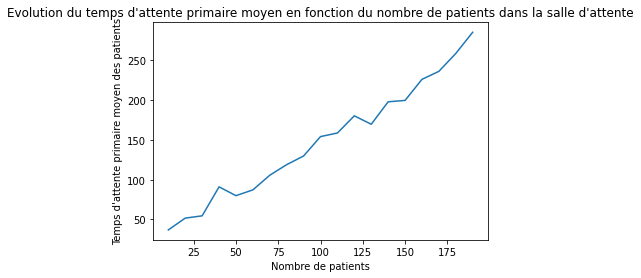

In [ ]:
import matplotlib.pyplot as plt

plt.plot(patients_liste, attente_moyenne)
plt.xlabel("Nombre de patients")
plt.ylabel("Temps d'attente primaire moyen des patients")
plt.title("Evolution du temps d'attente primaire moyen en fonction du nombre de patients dans la salle d'attente")
plt.show()

***Commentaire*** : 

On constate que la courbe d’évolution du temps d’attente primaire moyen en fonction du nombre de patients dans la zone d’attente suit une tendance ***linéaire***.

## Conclusion

Généralement, on constate que les performances de l'algorithme de liste sont plus ***meilleures*** que celles de l'algorithme génétique.

De plus, cet algorithme permet d'obtenir une solution optimale dans des délais les plus courts possibles. De l'autre côté, l'algorithme génétique se caractérise par une durée d'exécution et une consommation en mémoire assez conséquente. Ce qui est ***un paramètre important à prendre en compte surtout dans un milieu assez sensible comme les urgences***.